In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt 
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import PIL
from models.AlexNet import *
from models.ResNet import *
import os

In [7]:
dataPath='/home/fahad/data/streetContext/streetImages/Boston/modelRelated/data/resnetPOI/train/'
CAMPath='/home/fahad/data/streetContext/streetImages/Boston/modelRelated/cam/camImages'
ClassesFolders=[i for i in os.listdir(dataPath)]

In [8]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [9]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [10]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

base_transform = transforms.Compose([
    transforms.ToTensor()
    ])

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [11]:
#loading the model
startFromPath='/home/fahad/data/streetContext/streetImages/Boston/modelRelated/models/resnet18/BOS_POI_resnet18.348'
model = resnet_18()
model.load_state_dict(torch.load(startFromPath))
model.cuda()
model.eval()

ResNet(
  (Conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (Conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (Conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
#Then looping over images
for folder in ClassesFolders:
    for imageName in os.listdir(dataPath+folder):
        imagePath=dataPath+folder+'/'+imageName;
        targetPath=CAMPath+folder+'/'+imageName;
        
        #change this to get a path for every image

        image = Image.open(imagePath)
        #imshow(image)

        tensor = base_transform(image)
        prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

        final_layer = model._modules.get('layer4')

        activated_features = SaveFeatures(final_layer)

        prediction = model(prediction_var)
        pred_probabilities = F.softmax(prediction).data.squeeze()
        activated_features.remove()

        topk(pred_probabilities,1)
        weight_softmax_params = list(model._modules.get('fc').parameters())
        weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
        class_idx = topk(pred_probabilities,1)[1].int()
        overlay = getCAM(activated_features.features, weight_softmax, class_idx )
        fig1 = plt.gcf()
        plt.imshow(image)
        plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
        fig1.savefig(str(CAMPath+'/'+folder+'/'+imageName))
        

/home/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/home/fahad/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/fahad/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


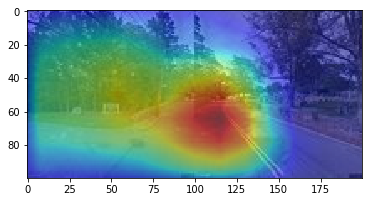